In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hr-analytics-job-change-of-data-scientists/sample_submission.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# **BUSINESS PROBLEM**

A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which conduct by the company. Many people signup for their training. Company wants to know which of these candidates are really wants to work for the company after training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment data.

The whole data divided to "train" and "test". Target isn't included in test.

# **PROJECT GOAL**

* Prediction of the probability of a candidate will work for the company.

In [3]:
train = pd.read_csv("/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv")
test = pd.read_csv("/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv")

In [4]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(pd.DataFrame({"NA_COUNT":dataframe.isnull().sum(),
                        "NA_RATIO":dataframe.isnull().sum() / len(dataframe)}))
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

# **FEATURES**

*** enrollee_id :** Unique ID for candidate

*** city:** City code

*** city_ development _index :** Development index of the city (scaled)

*** gender:** Gender of candidate

*** relevent_experience:** Relevant experience of candidate

*** enrolled_university:** Type of University course enrolled if any

*** education_level:** Education level of candidate

*** major_discipline:** Education major discipline of candidate

*** experience:** Candidate total experience in years

*** company_size:** Number of employees in current employer's company

*** company_type:** Type of current employer

*** lastnewjob:** Difference in years between previous job and current job

*** training_hours:** Training hours completed

*** target:** 0 – Not looking for job change, 1 – Looking for a job change

In [5]:
check_df(train)

##################### Shape #####################
(19158, 14)
##################### Types #####################
enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object
##################### NA #####################
                        NA_COUNT  NA_RATIO
enrollee_id                    0  0.000000
city                           0  0.000000
city_development_index         0  0.000000
gender                      4508  0.235306
relevent_experience            0  0.000000
enrolled_university          386  0.020148
education_level              460  0.024011
major_d

In [6]:
check_df(test)

##################### Shape #####################
(2129, 13)
##################### Types #####################
enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
dtype: object
##################### NA #####################
                        NA_COUNT  NA_RATIO
enrollee_id                    0  0.000000
city                           0  0.000000
city_development_index         0  0.000000
gender                       508  0.238610
relevent_experience            0  0.000000
enrolled_university           31  0.014561
education_level               52  0.024425
major_discipline             312  0.146548

# **APPROACH**

* First step is to divide the training dataset into two parts as "test_X" and "train" for validation as below. 

* Then to merge two parts of datasets which I created "train" and "test_X" with "test" set that already exist.

* To make feature transformation.

* To fill the missing values using KNN imputer.

* To use Light GBM algorithm for prediction.

* To use the metrics which called log-loss to prevent overfitting and roc-auc score for correct classification. 

* And finally, to predict the probability of working of a candidate on the test set which I will call "submission_df". 

In [7]:
# I created a test_df from train set for validation.
# I dropped the "target" values from test_X and I saved true target values as "results" dataframe.
test_df = train.iloc[:1000, :]
results = test_df[["enrollee_id", "target"]]


test_X = test_df.drop ("target", axis=1)
test_X

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,28500,city_21,0.624,NaN,Has relevent experience,Full time course,Graduate,STEM,<1,500-999,Pvt Ltd,1,22
996,10371,city_103,0.920,Female,No relevent experience,no_enrollment,Phd,STEM,7,500-999,Public Sector,4,28
997,10028,city_73,0.754,Male,Has relevent experience,no_enrollment,Graduate,STEM,15,1000-4999,Pvt Ltd,1,42
998,29671,city_40,0.776,Male,No relevent experience,Full time course,Graduate,STEM,9,NaN,NaN,1,50


In [8]:
# I merged test_X, train and test datasets for feature transformation.
df = pd.concat ([test_X, train.iloc[1000:, :], test], axis=0).reset_index (drop=True)
check_df (df)

##################### Shape #####################
(21287, 14)
##################### Types #####################
enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object
##################### NA #####################
                        NA_COUNT  NA_RATIO
enrollee_id                    0  0.000000
city                           0  0.000000
city_development_index         0  0.000000
gender                      5016  0.235637
relevent_experience            0  0.000000
enrolled_university          417  0.019589
education_level              512  0.024052
major_d

In [9]:
# I noticed that there is an imbalanced dataset problem.
df["target"].value_counts() / len(df)

0.0    0.639404
1.0    0.213605
Name: target, dtype: float64

In [10]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # Grabs the columns which is categorical, numerical, categorical but cardinal and numerical but categorical.
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique () < cat_th and
                   dataframe[col].dtypes != "O" or ("id" in col)]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique () > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print (f"Observations: {dataframe.shape[0]}")
    print (f"Variables: {dataframe.shape[1]}")
    print (f'cat_cols: {len (cat_cols)}')
    print (f'num_cols: {len (num_cols)}')
    print (f'cat_but_car: {len (cat_but_car)}')
    print (f'num_but_cat: {len (num_but_cat)}')

    return cat_cols, cat_but_car, num_cols, num_but_cat

In [11]:
categorical_cols, categorical_but_cardinal, numeric_cols, numeric_but_categorical = grab_col_names(df)

Observations: 21287
Variables: 14
cat_cols: 10
num_cols: 2
cat_but_car: 2
num_but_cat: 2


In [12]:
print("Categorical columns : {}".format(categorical_cols))
print("="*80)
print("Cat_But_Car columns : {}".format(categorical_but_cardinal))
print("="*80)
print("Numeric columns : {}".format(numeric_cols))
print("="*80)
print("Num_But_Cat columns : {}".format(numeric_but_categorical))


Categorical columns : ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type', 'last_new_job', 'enrollee_id', 'target']
Cat_But_Car columns : ['city', 'experience']
Numeric columns : ['city_development_index', 'training_hours']
Num_But_Cat columns : ['enrollee_id', 'target']


In [13]:
def cat_summary(dataframe, col_name, plot=False):
    # Shows summary of categorical columns.
    df = pd.DataFrame ({col_name: dataframe[col_name].value_counts (),
                          "Ratio": 100 * dataframe[col_name].value_counts () / len (dataframe)})
    print(df)

    if plot:
        plt.figure(figsize=(7,7))
        plt.pie (df["Ratio"], labels=df.index, 
                labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, autopct = "%1.1f%%",
                pctdistance=0.85, textprops={'fontsize': 10})
     
        #draw circle
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.show();
        print("="*50)

In [14]:
# Number of unique class of each feature.
df.nunique()

enrollee_id               21287
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
target                        2
dtype: int64

        gender      Ratio
Male     14681  68.966975
Female    1375   6.459341
Other      215   1.010006


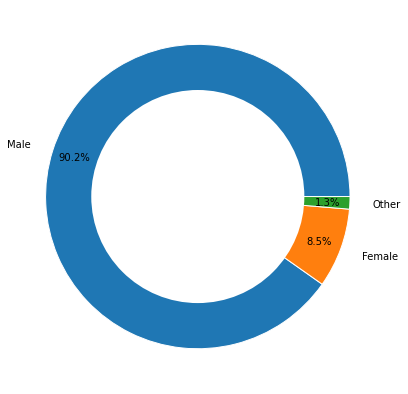

                         relevent_experience      Ratio
Has relevent experience                15316  71.950016
No relevent experience                  5971  28.049984


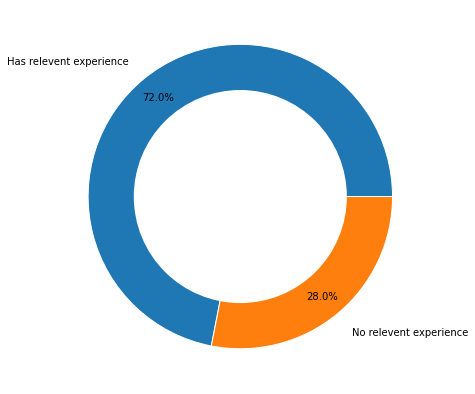

                  enrolled_university      Ratio
no_enrollment                   15336  72.043970
Full time course                 4192  19.692770
Part time course                 1342   6.304317


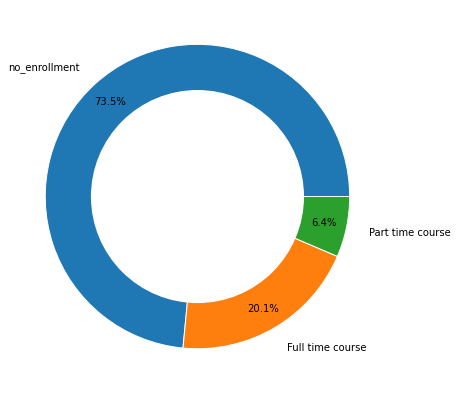

                education_level      Ratio
Graduate                  12867  60.445342
Masters                    4857  22.816743
High School                2239  10.518157
Phd                         468   2.198525
Primary School              344   1.616010


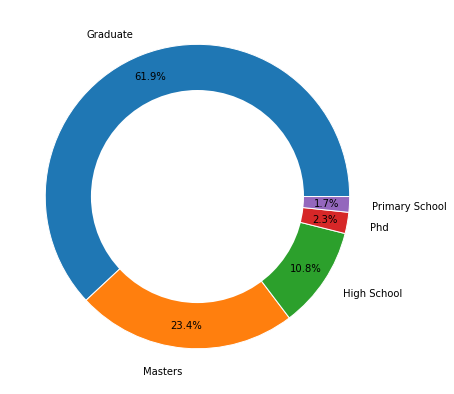

                 major_discipline      Ratio
STEM                        16113  75.694086
Humanities                    749   3.518579
Other                         421   1.977733
Business Degree               364   1.709964
Arts                          270   1.268380
No Major                      245   1.150937


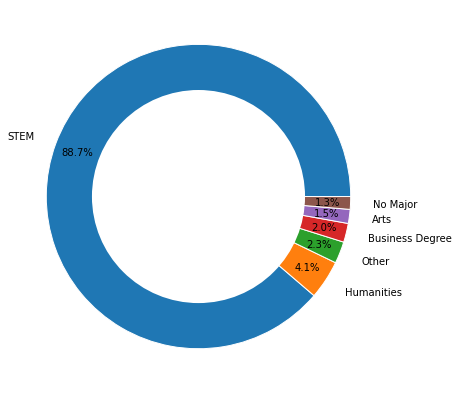

           company_size      Ratio
50-99              3421  16.070841
100-500            2889  13.571663
10000+             2236  10.504064
10/49              1643   7.718326
1000-4999          1471   6.910321
<10                1471   6.910321
500-999             965   4.533283
5000-9999           631   2.964250


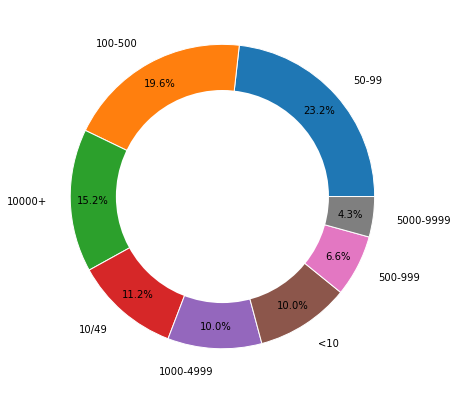

                     company_type      Ratio
Pvt Ltd                     10958  51.477428
Funded Startup               1098   5.158078
Public Sector                1082   5.082914
Early Stage Startup           668   3.138065
NGO                           574   2.696481
Other                         133   0.624794


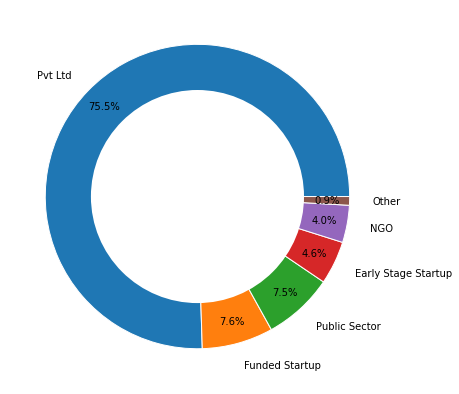

       last_new_job      Ratio
1              8924  41.922300
>4             3643  17.113731
2              3242  15.229953
never          2710  12.730775
3              1157   5.435242
4              1148   5.392963


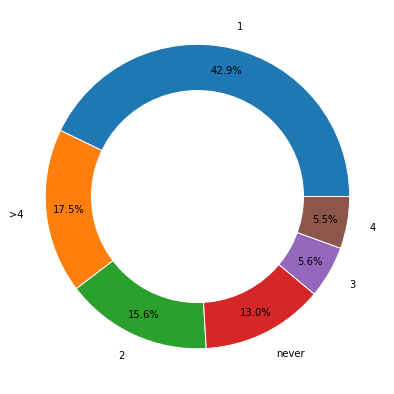

     target      Ratio
0.0   13611  63.940433
1.0    4547  21.360455


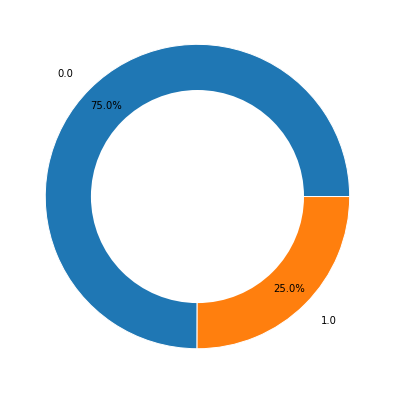

In [15]:
graph_cols = [col for col in categorical_cols if df[col].nunique() < 40]
for col in graph_cols:
    cat_summary (df, col, plot=True)

In [16]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    # Shows some of descriptive statistical metrics of target according to each categorical class.
    df = pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "TARGET_MEDIAN": dataframe.groupby(categorical_col)[target].median(),
                        "COUNT": dataframe.groupby(categorical_col)[target].count()})
    print(df)
    if plot==True:
        sns.barplot(x=df.index, y=df["TARGET_MEAN"])
        plt.xticks(rotation=45)
        plt.xlabel(df.index.name.upper())
        plt.show();
        print("="*50)

        TARGET_MEAN  TARGET_MEDIAN  COUNT
gender                                   
Female     0.261315            0.0   1171
Male       0.228455            0.0  12532
Other      0.258427            0.0    178


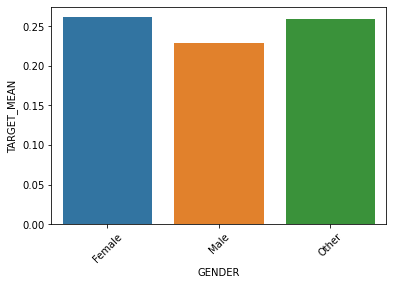

                         TARGET_MEAN  TARGET_MEDIAN  COUNT
relevent_experience                                       
Has relevent experience     0.215040            0.0  13072
No relevent experience      0.341329            0.0   5086


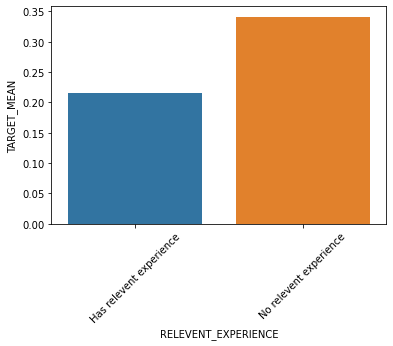

                     TARGET_MEAN  TARGET_MEDIAN  COUNT
enrolled_university                                   
Full time course        0.382782            0.0   3566
Part time course        0.251309            0.0   1146
no_enrollment           0.212272            0.0  13087


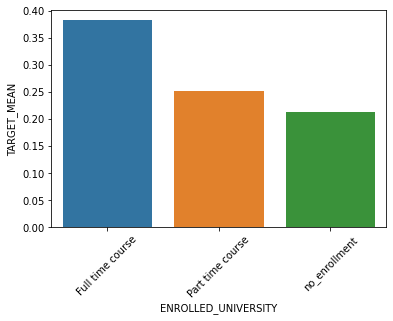

                 TARGET_MEAN  TARGET_MEDIAN  COUNT
education_level                                   
Graduate            0.280892            0.0  10990
High School         0.197595            0.0   1913
Masters             0.214182            0.0   4146
Phd                 0.144703            0.0    387
Primary School      0.131034            0.0    290


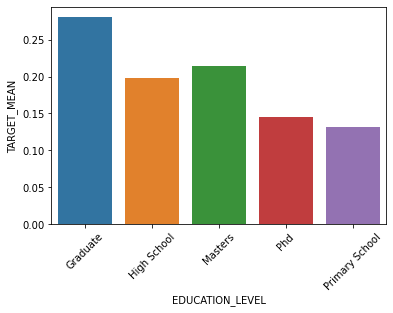

                  TARGET_MEAN  TARGET_MEDIAN  COUNT
major_discipline                                   
Arts                 0.209016            0.0    244
Business Degree      0.266026            0.0    312
Humanities           0.216216            0.0    629
No Major             0.255924            0.0    211
Other                0.273481            0.0    362
STEM                 0.261974            0.0  13738


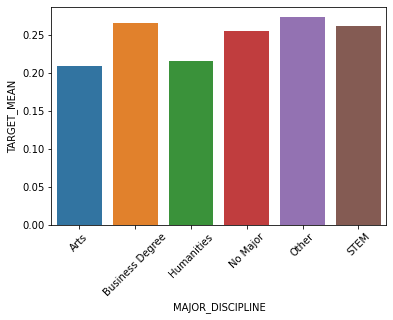

              TARGET_MEAN  TARGET_MEDIAN  COUNT
company_size                                   
10/49            0.236141            0.0   1389
100-500          0.160331            0.0   2420
1000-4999        0.153239            0.0   1266
10000+           0.194737            0.0   1900
50-99            0.175403            0.0   2919
500-999          0.172043            0.0    837
5000-9999        0.183019            0.0    530
<10              0.172249            0.0   1254


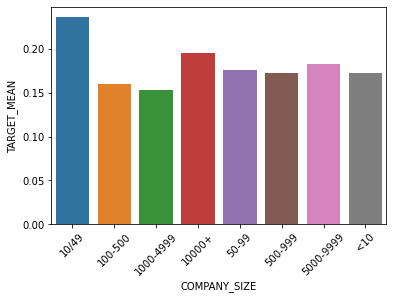

                     TARGET_MEAN  TARGET_MEDIAN  COUNT
company_type                                          
Early Stage Startup     0.241681            0.0    571
Funded Startup          0.138510            0.0    953
NGO                     0.188017            0.0    484
Other                   0.237288            0.0    118
Public Sector           0.222838            0.0    902
Pvt Ltd                 0.181398            0.0   9300


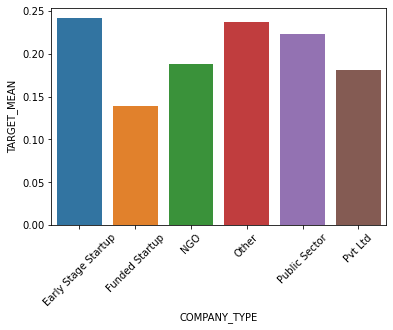

              TARGET_MEAN  TARGET_MEDIAN  COUNT
last_new_job                                   
1                0.266010            0.0   7620
2                0.240276            0.0   2751
3                0.224049            0.0    973
4                0.223251            0.0    972
>4               0.182168            0.0   3118
never            0.306299            0.0   2318


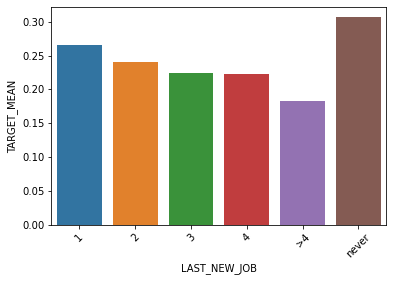

In [17]:
cats = [col for col in df.columns if (col in categorical_cols + categorical_but_cardinal) & (col not in ["enrollee_id","target"]) & (df[col].nunique() < 20)]
for col in cats:
    target_summary_with_cat(df, "target", col, plot=True)

In [18]:
def target_summary_with_num(dataframe, target, numerical_col):
    # Shows average of target according to numerical columns.
    df = dataframe.groupby (target).agg ({numerical_col: "mean"})
    print(df)
    print("="*50)


In [19]:
for col in numeric_cols:
    target_summary_with_num (df, "target", col)

        city_development_index
target                        
0.0                   0.853093
1.0                   0.756189
        training_hours
target                
0.0          66.205349
1.0          63.076094


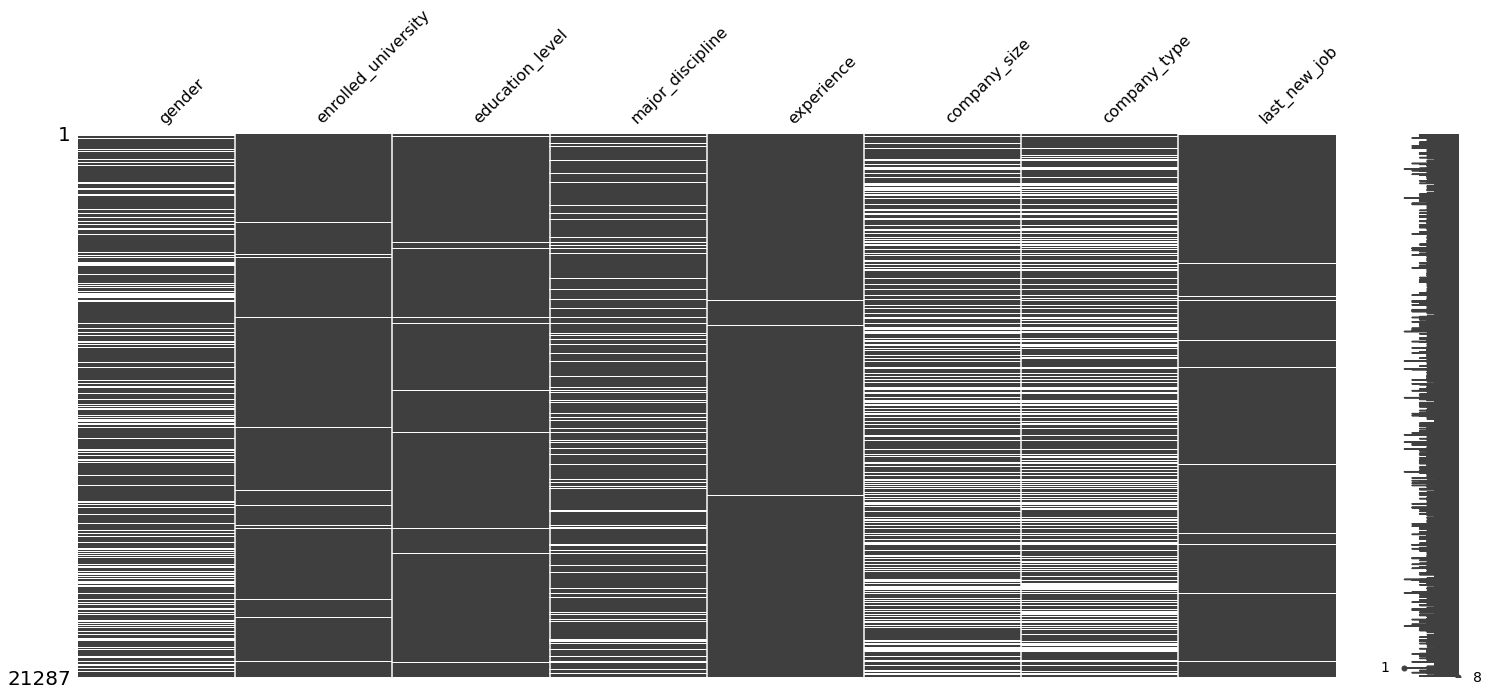

In [20]:
# Examining the missing values.
missing_cols = [col for col in df.columns if (df[col].isnull().any()) & (col != "target")]
msno.matrix(df[missing_cols]);

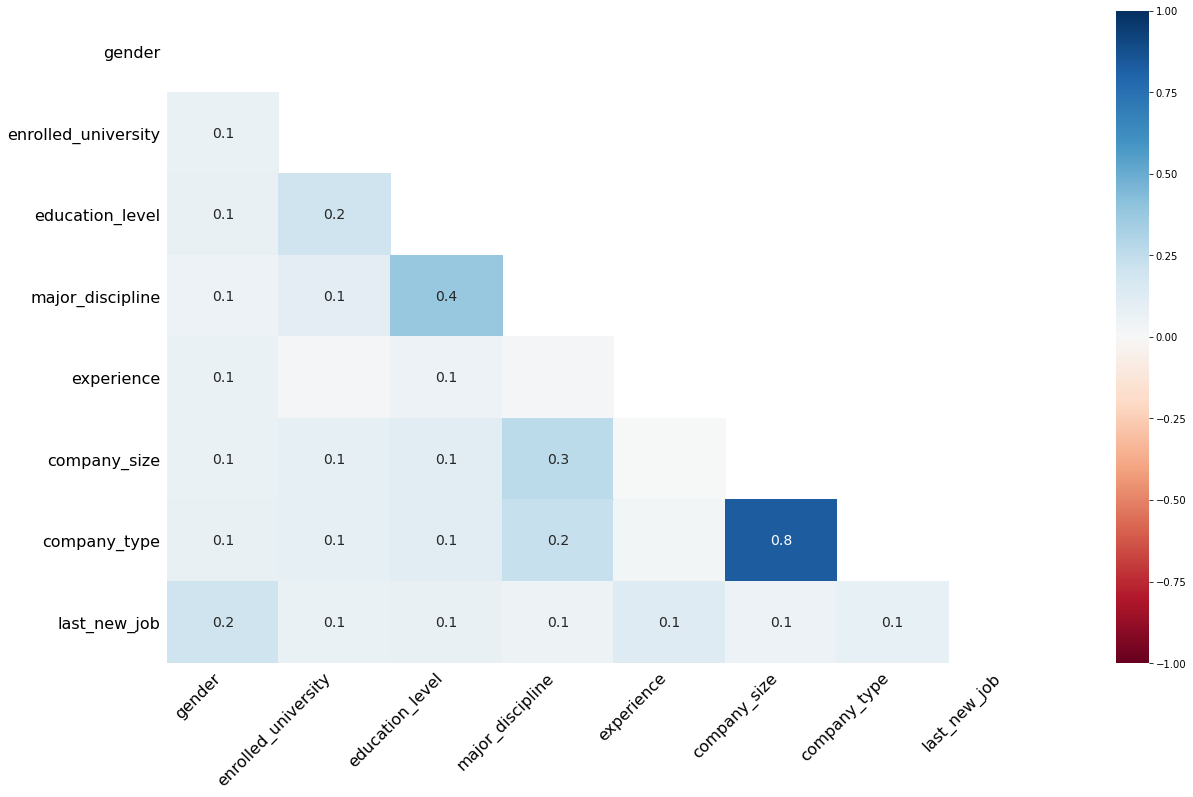

In [21]:
msno.heatmap(df[missing_cols]);

In [22]:

def data_prep(dataframe):
    # Labeling "relevent_experience" feature.
    dataframe.loc[dataframe["relevent_experience"] == "Has relevent experience", "NEW_IS_RELEVANT_EXP"] = 1
    dataframe.loc[dataframe["relevent_experience"] == "No relevent experience", "NEW_IS_RELEVANT_EXP"] = 0

    # Labeling "gender" feature.
    dataframe.loc[dataframe["gender"] == "Male", "NEW_GENDER"] = 0
    dataframe.loc[dataframe["gender"] == "Female", "NEW_GENDER"] = 1
    dataframe.loc[dataframe["gender"] == "Other", "NEW_GENDER"] = 2

    # Assigning the ones greater than 20 as 20, and the ones less than 1 as 0 and converting them to float.
    dataframe.loc[dataframe["experience"] == ">20", "experience"] = 20
    dataframe.loc[dataframe["experience"] == "<1", "experience"] = 0
    dataframe["NEW_EXPERIENCE"] = dataframe["experience"].astype (float)

    # Collecting the "last_new_job" under three groups.
    dataframe.loc[dataframe["last_new_job"].isin (["1", "2", "3", "4"]), "NEW_LAST_NEW_JOB"] = "1-4 years"
    dataframe.loc[dataframe["last_new_job"] == ">4", "NEW_LAST_NEW_JOB"] = "5+ years"
    dataframe.loc[dataframe["last_new_job"] == "never", "NEW_LAST_NEW_JOB"] = "never"

    # Dividing "major_discipline" into two groups as being STEM or not.
    Exc_STEM = [col for col in dataframe["major_discipline"].unique () if col not in ["STEM", np.nan]]
    dataframe.loc[dataframe["major_discipline"].isin (Exc_STEM), "NEW_MAJOR_is_STEM"] = 0
    dataframe.loc[(dataframe["major_discipline"] == "STEM"), "NEW_MAJOR_is_STEM"] = 1

    new_df = dataframe.copy()

    del_cols = ["gender", "relevent_experience", "experience", "last_new_job", "major_discipline"]

    new_df.drop (del_cols, axis=1, inplace=True)

    return new_df

In [23]:
df_2 = data_prep (df)
check_df(df_2)

##################### Shape #####################
(21287, 14)
##################### Types #####################
enrollee_id                 int64
city                       object
city_development_index    float64
enrolled_university        object
education_level            object
company_size               object
company_type               object
training_hours              int64
target                    float64
NEW_IS_RELEVANT_EXP       float64
NEW_GENDER                float64
NEW_EXPERIENCE            float64
NEW_LAST_NEW_JOB           object
NEW_MAJOR_is_STEM         float64
dtype: object
##################### NA #####################
                        NA_COUNT  NA_RATIO
enrollee_id                    0  0.000000
city                           0  0.000000
city_development_index         0  0.000000
enrolled_university          417  0.019589
education_level              512  0.024052
company_size                6560  0.308169
company_type                6774  0.318222
trainin

In [24]:
multiclass_cat_cols = [col for col in df_2.columns if (df_2[col].nunique () > 2) & (df_2[col].dtype == "O")]
multiclass_cat_cols

['city',
 'enrolled_university',
 'education_level',
 'company_size',
 'company_type',
 'NEW_LAST_NEW_JOB']

In [25]:
# Using Label Encoding for all multiclass categorical columns before filling the missing values.
df_2[multiclass_cat_cols] = df_2[multiclass_cat_cols].apply (lambda series: pd.Series (
    LabelEncoder ().fit_transform (series[series.notnull ()]),
    index=series[series.notnull ()].index))

In [26]:
df_2.head()

,enrollee_id,city,city_development_index,enrolled_university,education_level,company_size,company_type,training_hours,target,NEW_IS_RELEVANT_EXP,NEW_GENDER,NEW_EXPERIENCE,NEW_LAST_NEW_JOB,NEW_MAJOR_is_STEM
0,8949,5,0.920,2.0,0.0,NaN,NaN,36,NaN,1.0,0.0,20.0,0.0,1.0
1,29725,77,0.776,2.0,0.0,4.0,5.0,47,NaN,0.0,0.0,15.0,1.0,1.0
2,11561,64,0.624,0.0,0.0,NaN,NaN,83,NaN,0.0,NaN,5.0,2.0,1.0
3,33241,14,0.789,NaN,0.0,NaN,5.0,52,NaN,0.0,NaN,0.0,2.0,0.0
4,666,50,0.767,2.0,2.0,4.0,1.0,8,NaN,1.0,0.0,20.0,0.0,1.0


In [27]:
def knn_imputer_test(data, n_neighbors_list, model_name):
    # Returns n_neighbor value which has the best roc_auc score for given n_neigbor lists.
    best_roc_auc = 0
    best_n_neighbor = 0

    for n in n_neighbors_list:
        dataframe = data.copy ()
        imputed_cols = [col for col in dataframe.columns if
                        (col not in ["target", "enrollee_id"]) & (dataframe[col].isnull ().any ())]
        knn_imputer = KNNImputer (n_neighbors=n)
        dataframe[imputed_cols] = np.round (knn_imputer.fit_transform (dataframe[imputed_cols]))

        train_data = dataframe[dataframe.notnull ().all (axis=1)]

        # MODEL
        X = train_data.drop (["enrollee_id", "target"], axis=1)
        y = train_data['target']

        # Data upscaling
        smote = SMOTE ()
        X, y = smote.fit_resample (X, y)

        X_train, X_test, y_train, y_test = train_test_split (X, y, random_state=17, test_size=0.2)

        model = model_name
        fit_model = model.fit (X_train, y_train)
        y_probs = fit_model.predict_proba (X_test)
        y_probs = y_probs[:, 1]

        roc_auc = roc_auc_score (y_test, y_probs)

        print ("n_neighbors : {}   //   roc_auc_score : {}".format (n, roc_auc))
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_n_neighbor = n
        else:
            continue
    return best_roc_auc, best_n_neighbor

In [28]:
new_df = df_2.copy()

In [29]:
lgbm_roc_auc, lgbm_n_neighbor = knn_imputer_test (new_df, range (2, 11), LGBMClassifier (random_state=17))

n_neighbors : 2   //   roc_auc_score : 0.9205902305916283
n_neighbors : 3   //   roc_auc_score : 0.9231163574013727
n_neighbors : 4   //   roc_auc_score : 0.9224027409133644
n_neighbors : 5   //   roc_auc_score : 0.9248589767530221
n_neighbors : 6   //   roc_auc_score : 0.9260575799050776
n_neighbors : 7   //   roc_auc_score : 0.925431192205025
n_neighbors : 8   //   roc_auc_score : 0.9270415853970508
n_neighbors : 9   //   roc_auc_score : 0.9263968479442342
n_neighbors : 10   //   roc_auc_score : 0.9266302675933652


In [30]:
print("LGBM best roc_auc : {}  // LGBM n_neighbor : {}".format(lgbm_roc_auc, lgbm_n_neighbor))

LGBM best roc_auc : 0.9270415853970508  // LGBM n_neighbor : 8


In [31]:
# Columns to be filled.
imputed_cols = [col for col in new_df.columns if 
                (col not in ["target", "enrollee_id"]) & (new_df[col].isnull().any())]
imputed_cols

['enrolled_university',
 'education_level',
 'company_size',
 'company_type',
 'NEW_GENDER',
 'NEW_EXPERIENCE',
 'NEW_LAST_NEW_JOB',
 'NEW_MAJOR_is_STEM']

# **FILLING THE MISSING VALUES USING KNN IMPUTER**

In [32]:
knn_imputer = KNNImputer (n_neighbors=lgbm_n_neighbor)
new_df[imputed_cols] = np.round(knn_imputer.fit_transform (new_df[imputed_cols]))

In [33]:
prep_df = new_df.copy ()
check_df(prep_df)

##################### Shape #####################
(21287, 14)
##################### Types #####################
enrollee_id                 int64
city                        int64
city_development_index    float64
enrolled_university       float64
education_level           float64
company_size              float64
company_type              float64
training_hours              int64
target                    float64
NEW_IS_RELEVANT_EXP       float64
NEW_GENDER                float64
NEW_EXPERIENCE            float64
NEW_LAST_NEW_JOB          float64
NEW_MAJOR_is_STEM         float64
dtype: object
##################### NA #####################
                        NA_COUNT  NA_RATIO
enrollee_id                    0  0.000000
city                           0  0.000000
city_development_index         0  0.000000
enrolled_university            0  0.000000
education_level                0  0.000000
company_size                   0  0.000000
company_type                   0  0.000000
trainin

In [34]:
# Dividing dataset into three parts as test_data, subb_data and train_data.
test_data = prep_df.loc[prep_df["enrollee_id"].isin (results["enrollee_id"])].reset_index(drop=True)
subb_data = prep_df.loc[prep_df["enrollee_id"].isin (test["enrollee_id"])].reset_index(drop=True)
train_data = prep_df[prep_df.notnull ().all (axis=1)].reset_index(drop=True)

In [35]:
subb_data.head()

,enrollee_id,city,city_development_index,enrolled_university,education_level,company_size,company_type,training_hours,target,NEW_IS_RELEVANT_EXP,NEW_GENDER,NEW_EXPERIENCE,NEW_LAST_NEW_JOB,NEW_MAJOR_is_STEM
0,32403,78,0.827,0.0,0.0,7.0,3.0,21,NaN,1.0,0.0,9.0,0.0,1.0
1,9858,5,0.920,2.0,0.0,2.0,5.0,98,NaN,1.0,1.0,5.0,0.0,1.0
2,31806,64,0.624,2.0,1.0,4.0,5.0,15,NaN,0.0,0.0,0.0,2.0,1.0
3,27385,26,0.827,2.0,2.0,0.0,5.0,39,NaN,1.0,0.0,11.0,0.0,1.0
4,27724,5,0.920,2.0,0.0,3.0,5.0,72,NaN,1.0,0.0,20.0,1.0,1.0


In [36]:
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


# **LGBM MODEL**

In [37]:
# Using train_data for setting up lgbm model.
X = train_data.drop (["enrollee_id", "target"], axis=1)
y = train_data['target']

In [38]:
# Imbalanced dataset.
y.value_counts () / len(y)

0.0    0.749587
1.0    0.250413
Name: target, dtype: float64

In [39]:
def plot_learning_curve(model, X, Y):
    # Plots logistic loss values for train and test sets.
    x_train, x_test, y_train, y_test = train_test_split (X, Y, test_size=0.2, random_state=17)
    train_loss, test_loss = [], []

    for m in range (200, len (x_train), 200):
        model.fit (x_train.iloc[:m, :], y_train[:m])
        y_train_prob_pred = model.predict_proba (x_train.iloc[:m, :])
        train_loss.append (log_loss (y_train[:m], y_train_prob_pred))

        y_test_prob_pred = model.predict_proba (x_test)
        test_loss.append (log_loss (y_test, y_test_prob_pred))

    plt.figure (figsize=(15, 8))
    plt.plot (train_loss, 'r-+', label='Training Loss')
    plt.plot (test_loss, 'b-', label='Test Loss')
    plt.xlabel ('Number Of Batches')
    plt.ylabel ('Log-Loss')
    plt.legend (loc='best')

    plt.show ()

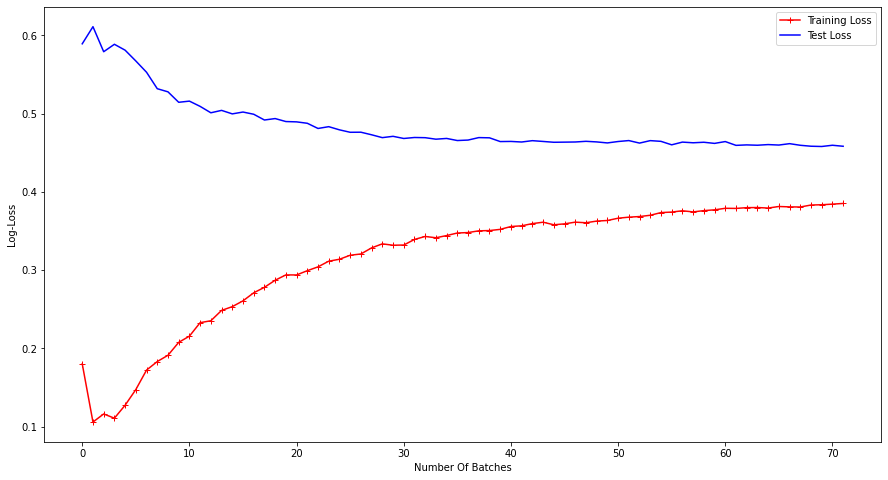

In [40]:
plot_learning_curve(LGBMClassifier(random_state=17), X, y)

In [41]:
# Data Upscaling for decreasing log_loss values
smote = SMOTE (random_state=17)
X_smote, y_smote = smote.fit_resample (X, y)

In [42]:
# SMOTE 2
X_smote1, y_smote1 = smote.fit_resample(X,y)

In [43]:
# SMOTE 3
X_smote2, y_smote2 = smote.fit_resample(X,y)

In [44]:
X_final = pd.concat([X_smote, X_smote1, X_smote2]).reset_index(drop=True)
y_final = pd.concat([y_smote, y_smote1, y_smote2]).reset_index(drop=True)

In [45]:
y_final.value_counts()

0.0    40833
1.0    40833
Name: target, dtype: int64

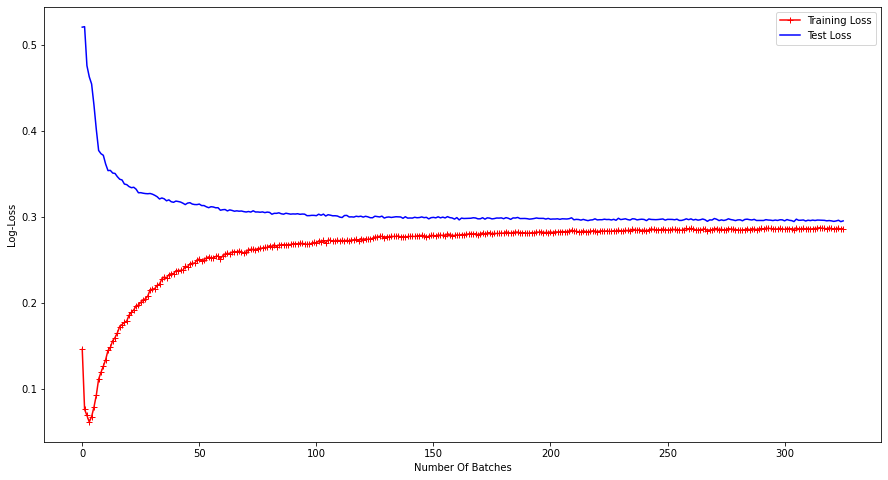

In [46]:
plot_learning_curve(LGBMClassifier(random_state=17), X_final, y_final)

In [47]:
X_train, X_val, y_train, y_val = train_test_split (X_final, y_final, random_state=17, test_size=0.2)

In [48]:
lgbm = LGBMClassifier (random_state=17)
lgbm_model = lgbm.fit (X_train, y_train)

In [49]:
# Train Set Score
train_preds = lgbm_model.predict (X_train)
train_probs = lgbm_model.predict_proba (X_train)
train_probs = train_probs[:, 1]
print (classification_report (y_train, train_preds))
print ("Roc_Auc Score : {}".format(roc_auc_score (y_train, train_probs)))

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87     32647
         1.0       0.89      0.85      0.87     32685

    accuracy                           0.87     65332
   macro avg       0.87      0.87      0.87     65332
weighted avg       0.87      0.87      0.87     65332

Roc_Auc Score : 0.9500242025526798


In [50]:
# Validation Set Score
y_pred = lgbm_model.predict (X_val)
probs_model = lgbm_model.predict_proba (X_val)
probs_model = probs_model[:, 1]

print (classification_report (y_val, y_pred))
print ("Roc_Auc Score : {}".format(roc_auc_score (y_val, probs_model)))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      8186
         1.0       0.88      0.85      0.86      8148

    accuracy                           0.87     16334
   macro avg       0.87      0.87      0.87     16334
weighted avg       0.87      0.87      0.87     16334

Roc_Auc Score : 0.9437685750939647


In [51]:
# MODEL TUNING
lgbm_params = {"num_leaves": [20, 50],
               "max_depth": [5, 8],
               "learning_rate": [0.005, 0.01, 0.02],
               "n_estimators": [100, 500, 1000]}

lgbm_cv = GridSearchCV (lgbm, lgbm_params, cv=5, n_jobs=-1, verbose=2).fit (X_train, y_train)

lgbm_cv.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 1000, 'num_leaves': 50}

In [52]:
# FINAL MODEL
lgbm_tuned = LGBMClassifier (random_state=17, **lgbm_cv.best_params_).fit (X_train, y_train)
y_tuned = lgbm_tuned.predict (X_val)
probs_final = lgbm_tuned.predict_proba (X_val)
probs_final = probs_final[:, 1]

In [53]:
# Validation Set Score with Final Model
print (classification_report (y_val, y_tuned))
print ("Roc_Auc Score : {}".format(roc_auc_score (y_val, probs_final)))

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      8186
         1.0       0.91      0.87      0.89      8148

    accuracy                           0.89     16334
   macro avg       0.89      0.89      0.89     16334
weighted avg       0.89      0.89      0.89     16334

Roc_Auc Score : 0.9615417593359882


In [54]:
def roc_auc_plot(model_name, testX, ytrue):
    probs = model_name.predict_proba(testX)
    probs = probs [:,1]
    fpr, tpr, threshold = roc_curve (ytrue, probs)
    roc_auc = roc_auc_score (ytrue, probs)

    plt.title ('Receiver Operating Characteristic')
    plt.plot (fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend (loc='lower right')
    plt.plot ([0, 1], [0, 1], 'r--')
    plt.xlim ([0, 1])
    plt.ylim ([0, 1])
    plt.ylabel ('True Positive Rate')
    plt.xlabel ('False Positive Rate')
    plt.show ();

    return roc_auc


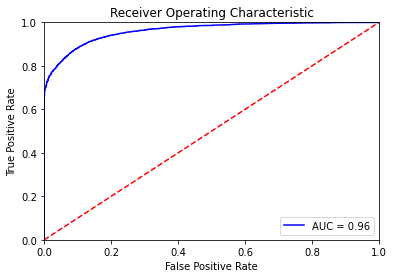

0.9615417593359882

In [55]:
roc_auc_plot(lgbm_tuned, X_val, y_val)

In [56]:
# Using tuned model into test_data which extracting from train set at the beginning.
test_data

,enrollee_id,city,city_development_index,enrolled_university,education_level,company_size,company_type,training_hours,target,NEW_IS_RELEVANT_EXP,NEW_GENDER,NEW_EXPERIENCE,NEW_LAST_NEW_JOB,NEW_MAJOR_is_STEM
0,8949,5,0.920,2.0,0.0,3.0,4.0,36,NaN,1.0,0.0,20.0,0.0,1.0
1,29725,77,0.776,2.0,0.0,4.0,5.0,47,NaN,0.0,0.0,15.0,1.0,1.0
2,11561,64,0.624,0.0,0.0,5.0,4.0,83,NaN,0.0,0.0,5.0,2.0,1.0
3,33241,14,0.789,2.0,0.0,3.0,5.0,52,NaN,0.0,0.0,0.0,2.0,0.0
4,666,50,0.767,2.0,2.0,4.0,1.0,8,NaN,1.0,0.0,20.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,28500,64,0.624,0.0,0.0,5.0,5.0,22,NaN,1.0,0.0,0.0,0.0,1.0
996,10371,5,0.920,2.0,3.0,5.0,4.0,28,NaN,0.0,1.0,7.0,0.0,1.0
997,10028,101,0.754,2.0,0.0,2.0,5.0,42,NaN,1.0,0.0,15.0,0.0,1.0
998,29671,77,0.776,0.0,0.0,4.0,4.0,50,NaN,0.0,0.0,9.0,0.0,1.0


In [57]:
results

,enrollee_id,target
0,8949,1.0
1,29725,0.0
2,11561,0.0
3,33241,1.0
4,666,0.0
...,...,...
995,28500,0.0
996,10371,0.0
997,10028,0.0
998,29671,0.0


In [58]:
test_labels = results["target"]

In [59]:
test_data_X = test_data.drop (["enrollee_id", "target"], axis=1)

lgbm_final_pred = lgbm_tuned.predict (test_data_X)
lgbm_final_probs = lgbm_tuned.predict_proba (test_data_X)
lgbm_final_probs = lgbm_final_probs[:, 1]


In [60]:
print (classification_report (test_labels, lgbm_final_pred))
print ("Roc_Auc Score : {}".format(roc_auc_score (test_labels, lgbm_final_probs)))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       770
         1.0       0.58      0.49      0.53       230

    accuracy                           0.80      1000
   macro avg       0.72      0.69      0.70      1000
weighted avg       0.79      0.80      0.79      1000

Roc_Auc Score : 0.8012732919254658


In [61]:
def con_matrix(true_labels, pred_labels):
    # Plots confusion matrix as a heatmap.
    matrix = confusion_matrix (true_labels, pred_labels)
    sns.heatmap (matrix, annot=True, fmt="d")
    plt.xlabel ("Predicted")
    plt.ylabel ("Actual")
    plt.show ();

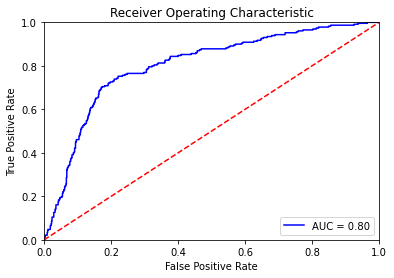

0.8012732919254658

In [62]:
roc_auc_plot (lgbm_tuned, test_data_X, test_labels)

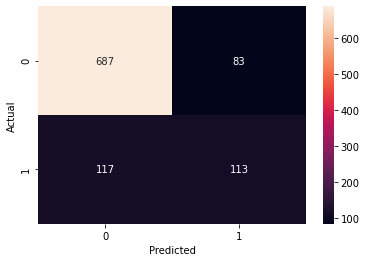

In [63]:
con_matrix (test_labels, lgbm_final_pred)

# **SUBMISSION**

In [64]:
subb_data.head()

,enrollee_id,city,city_development_index,enrolled_university,education_level,company_size,company_type,training_hours,target,NEW_IS_RELEVANT_EXP,NEW_GENDER,NEW_EXPERIENCE,NEW_LAST_NEW_JOB,NEW_MAJOR_is_STEM
0,32403,78,0.827,0.0,0.0,7.0,3.0,21,NaN,1.0,0.0,9.0,0.0,1.0
1,9858,5,0.920,2.0,0.0,2.0,5.0,98,NaN,1.0,1.0,5.0,0.0,1.0
2,31806,64,0.624,2.0,1.0,4.0,5.0,15,NaN,0.0,0.0,0.0,2.0,1.0
3,27385,26,0.827,2.0,2.0,0.0,5.0,39,NaN,1.0,0.0,11.0,0.0,1.0
4,27724,5,0.920,2.0,0.0,3.0,5.0,72,NaN,1.0,0.0,20.0,1.0,1.0


In [65]:
subb_X = subb_data.drop(["enrollee_id","target"], axis=1)

In [66]:
prediction = lgbm_tuned.predict_proba(subb_X)
prediction[:5]

array([[0.73385583, 0.26614417],
       [0.90541434, 0.09458566],
       [0.58903434, 0.41096566],
       [0.93116633, 0.06883367],
       [0.73763509, 0.26236491]])

In [67]:
predict = prediction[:,1]
predict[:5]

array([0.26614417, 0.09458566, 0.41096566, 0.06883367, 0.26236491])

In [68]:
submission_df = pd.DataFrame({"enrollee_id":subb_data["enrollee_id"],
             "target":predict})

submission_df.head()

,enrollee_id,target
0,32403,0.266144
1,9858,0.094586
2,31806,0.410966
3,27385,0.068834
4,27724,0.262365


In [69]:
submission_df.to_csv('submission.csv',index=False)